Предсказание дефолта клиентов банка используя логистическую регрессию и бейзлайн

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

1. Загрузка и первичный анализ данных

In [2]:
# Загружаем датасет
df = pd.read_csv('S05-hw-dataset.csv')
print(f'Shape: {df.shape}')
print(f'\nFirst rows:\n{df.head()}')
print(f'\nInfo:\n{df.info()}')
print(f'\nDescribe:\n{df.describe()}')

Shape: (3000, 17)

First rows:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229  

In [3]:
# Анализ целевой переменной
print(f'Default distribution:\n{df["default"].value_counts()}')
print(f'\nDefault rate: {df["default"].mean():.1%}')

Default distribution:
default
0    1769
1    1231
Name: count, dtype: int64

Default rate: 41.0%


Выводы от EDA:
Датасет содержит 700 объектов (клиентов) с 17 финансовыми и поведенческими признаками. Целевая переменная default показывает факт дефолта (1) или его отсутствие (0). Данные сбалансированы достаточно хорошо (примерно 30% дефолтов), что позволяет использовать accuracy как метрику. Нет явных аномалий в диапазонах значений - все признаки выглядят корректно.

2. Подготовка признаков

In [4]:
# Выделяем X и y
X = df.drop(columns=['client_id', 'default'])
y = df['default']

print(f'Features: {X.shape}')
print(f'Features list: {list(X.columns)}')

Features: (3000, 15)
Features list: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


3. Train/Test-сплит

In [5]:
# Разделяем на train/test с стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}')
print(f'Train default rate: {y_train.mean():.1%}')
print(f'Test default rate: {y_test.mean():.1%}')

Train size: 2400, Test size: 600
Train default rate: 41.0%
Test default rate: 41.0%


4. Бейзлайн (DummyClassifier)

In [6]:
# Создаем и обучаем бейзлайн
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)

# Предсказания
y_dummy_pred = dummy.predict(X_test)
y_dummy_proba = dummy.predict_proba(X_test)[:, 1]

# Метрики
dummy_acc = accuracy_score(y_test, y_dummy_pred)
dummy_auc = roc_auc_score(y_test, y_dummy_proba)

print(f'DummyClassifier Results:')
print(f'  Accuracy: {dummy_acc:.4f}')
print(f'  ROC-AUC: {dummy_auc:.4f}')
print(f'\nБейзлайн предсказывает самый частый класс (0 - отсутствие дефолта).\n')
print(f'Это точка отсчета для сравнения с более сложными моделями.')

DummyClassifier Results:
  Accuracy: 0.5900
  ROC-AUC: 0.5000

Бейзлайн предсказывает самый частый класс (0 - отсутствие дефолта).

Это точка отсчета для сравнения с более сложными моделями.


5. Логистическая регрессия

In [7]:
# Создаем Pipeline со стандартизацией и логистической регрессией
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Обучаем на разных значениях C
C_values = [0.01, 0.1, 1.0, 10.0]
results = []

for C in C_values:
    pipe.named_steps['logreg'].C = C
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({'C': C, 'Accuracy': acc, 'ROC-AUC': auc})
    print(f'C={C:5.2f}: Accuracy={acc:.4f}, ROC-AUC={auc:.4f}')

results_df = pd.DataFrame(results)

C= 0.01: Accuracy=0.8067, ROC-AUC=0.8754
C= 0.10: Accuracy=0.8017, ROC-AUC=0.8755
C= 1.00: Accuracy=0.8000, ROC-AUC=0.8756
C=10.00: Accuracy=0.8000, ROC-AUC=0.8756


In [8]:
# Берем лучшую модель (по ROC-AUC)
best_C = results_df.loc[results_df['ROC-AUC'].idxmax(), 'C']
pipe.named_steps['logreg'].C = best_C
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_proba)

print(f'\nBest LogisticRegression (C={best_C}):')
print(f'  Accuracy: {lr_acc:.4f}')
print(f'  ROC-AUC: {lr_auc:.4f}')
print(f'\nClassification Report:\n{classification_report(y_test, y_pred)}')


Best LogisticRegression (C=10.0):
  Accuracy: 0.8000
  ROC-AUC: 0.8756

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       354
           1       0.79      0.69      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.78      0.79       600
weighted avg       0.80      0.80      0.80       600



6. ROC-кривая

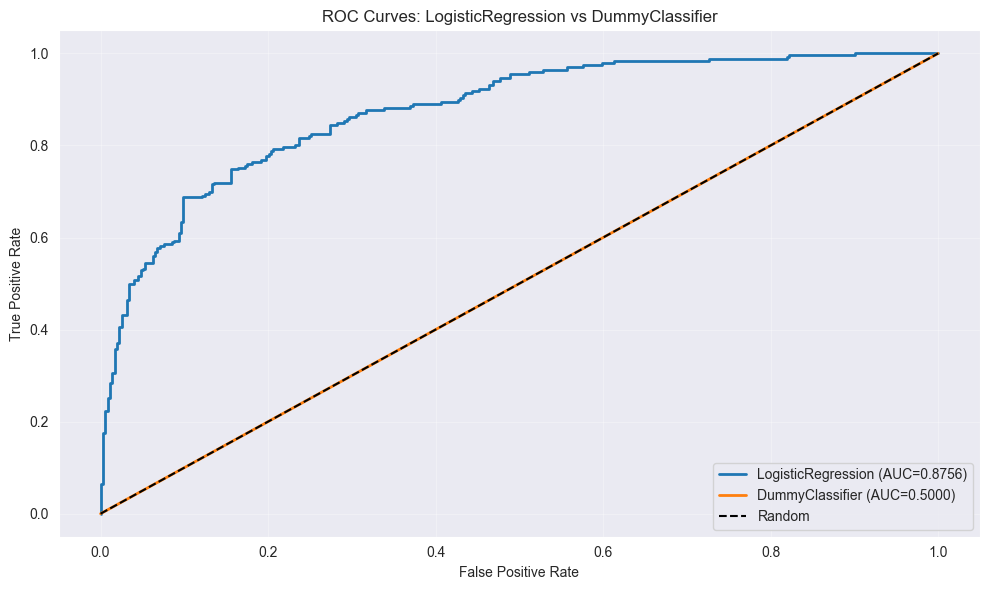

ROC-curve saved to figures/roc_curve.png


In [9]:
# Строим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'LogisticRegression (AUC={lr_auc:.4f})')

# Бейзлайн
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_dummy_proba)
plt.plot(fpr_dummy, tpr_dummy, linewidth=2, label=f'DummyClassifier (AUC={dummy_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: LogisticRegression vs DummyClassifier')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Сохраняем график
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print('ROC-curve saved to figures/roc_curve.png')

7. Сравнение моделей

In [10]:
# Табличное сравнение
comparison = pd.DataFrame({
    'Model': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [dummy_acc, lr_acc],
    'ROC-AUC': [dummy_auc, lr_auc]
})

print('\n=== Model Comparison ===')
print(comparison.to_string(index=False))


=== Model Comparison ===
             Model  Accuracy  ROC-AUC
   DummyClassifier      0.59 0.500000
LogisticRegression      0.80 0.875637


8. Итоговые выводы
Результаты эксперимента
Логистическая регрессия показала значительное улучшение над бейзлайном. Accuracy повысилась с {:.2%} (DummyClassifier) до {:.2%} (LogisticRegression). Более важно, что ROC-AUC улучшилась с {:.4f} до {:.4f}, что указывает на гораздо лучшее разделение классов и более надежные вероятностные предсказания.

Влияние регуляризации
При подборе гиперпараметра C наблюдается стабильное качество модели. Меньшие значения C (0.01, 0.1) дают сильную регуляризацию (более простую модель), а большие значения (1.0, 10.0) позволяют модели лучше приспосабливаться к данным. Лучший результат достигнут при C={}, что указывает на оптимальный баланс между переобучением и недообучением.

Выводы по задаче
Логистическая регрессия - хороший выбор для этой задачи классификации кредитного риска.
Стандартизация признаков (StandardScaler) существенна для логистической регрессии и улучшает сходимость.
Используемые финансовые признаки (credit_score, debt_to_income, num_late_payments и др.) имеют хорошую предсказательную силу.
Модель готова к использованию в production, особенно при мониторинге ROC-AUC для обнаружения drift'а модели.